In [161]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
import matplotlib.pyplot as plt

In [220]:
def yield_plot(sr,tot, name):
    nggF_sel = sr[('ggF-minlo',)]
    nVBF_sel = sr[('VBF',)]
    nWH_sel = sr[('WH',)]
    nZH_sel = sr[('ZH',)]
    nttH_sel = sr[('ttH',)]

    nggF = tot[('ggF-minlo',)]
    nVBF = tot[('VBF',)]
    nWH = tot[('WH',)]
    nZH = tot[('ZH',)]
    nttH = tot[('ttH',)]

    sr_name = name+'-like'
    categories = [sr_name,'other']
    
    ggF = [nggF_sel, nggF-nggF_sel]
    VBF = [nVBF_sel, nVBF-nVBF_sel]
    WH = [nWH_sel, nWH-nWH_sel]
    ZH = [nZH_sel, nZH-nZH_sel]
    ttH = [nttH_sel, nttH-nttH_sel]

    bars1 = ggF
    bars2 = [ggF[0]+VBF[0],ggF[1]+VBF[1]]
    bars3 = [ggF[0]+VBF[0]+WH[0],ggF[1]+VBF[1]+WH[1]]
    bars4 = [ggF[0]+VBF[0]+WH[0]+ZH[0],ggF[1]+VBF[1]+WH[1]+ZH[1]]
    
    plt.bar(categories, ggF, 1, color='red', label='ggF')
    plt.bar(categories, VBF, 1, color='orange',bottom=bars1, label='VBF')
    plt.bar(categories, WH, 1, color='green',bottom=bars2, label='WH')
    plt.bar(categories, ZH, 1, color='blue',bottom=bars3, label='ZH')
    plt.bar(categories, ttH, 1, color='purple',bottom=bars4, label='ttH')
    plt.ylabel('Events at 41.1 fb-1')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig_name = name+'_yield.png'
    plt.savefig(fig_name,bbox_inches='tight')
    
def purity_plot(sr, tot, name):
    nggF_sel = sr[('ggF-minlo',)]
    nVBF_sel = sr[('VBF',)]
    nWH_sel = sr[('WH',)]
    nZH_sel = sr[('ZH',)]
    nttH_sel = sr[('ttH',)]
    sum_sel = nggF_sel+nVBF_sel+nWH_sel+nZH_sel+nttH_sel

    nggF = tot[('ggF-minlo',)]
    nVBF = tot[('VBF',)]
    nWH = tot[('WH',)]
    nZH = tot[('ZH',)]
    nttH = tot[('ttH',)]
    sum_all = nggF+nVBF+nWH+nZH+nttH

    sr_name = name+'-like'
    categories = [sr_name,'other']
    
    ggF = [1.0*nggF_sel/sum_sel, 1.0*(nggF-nggF_sel)/(sum_all-sum_sel)]
    VBF = [1.0*nVBF_sel/sum_sel, 1.0*(nVBF-nVBF_sel)/(sum_all-sum_sel)]
    WH = [1.0*nWH_sel/sum_sel, 1.0*(nWH-nWH_sel)/(sum_all-sum_sel)]
    ZH = [1.0*nZH_sel/sum_sel, 1.0*(nZH-nZH_sel)/(sum_all-sum_sel)]
    ttH = [1.0*nttH_sel/sum_sel, 1.0*(nttH-nttH_sel)/(sum_all-sum_sel)]
    
    print(ggF)
    print(VBF)
    print(WH)
    print(ZH)
    print(ttH)
    
    bars1 = ggF
    bars2 = [ggF[0]+VBF[0],ggF[1]+VBF[1]]
    bars3 = [ggF[0]+VBF[0]+WH[0],ggF[1]+VBF[1]+WH[1]]
    bars4 = [ggF[0]+VBF[0]+WH[0]+ZH[0],ggF[1]+VBF[1]+WH[1]+ZH[1]]
    
    plt.bar(categories, ggF, 1, color='red', label='ggF')
    plt.bar(categories, VBF, 1, color='orange',bottom=bars1, label='VBF')
    plt.bar(categories, WH, 1, color='green',bottom=bars2, label='WH')
    plt.bar(categories, ZH, 1, color='blue',bottom=bars3, label='ZH')
    plt.bar(categories, ttH, 1, color='purple',bottom=bars4, label='ttH')
    plt.ylabel('Fraction of Higgs signal')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig_name = name+'_purity.png'
    plt.savefig(fig_name,bbox_inches='tight')

In [163]:
names=['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8',
       'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8',
       'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8',
       'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8',
       'GluGluHToBB_M125_13TeV_powheg_pythia8',
       'GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8',
       'VBFHToBB_M-125_13TeV_powheg_pythia8',
       'WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8',
       'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8',
       'ttHTobb_M125_13TeV-powheg-pythia8'
      ]

with open('xsec.json') as f:
  xs = json.load(f)

In [164]:
lumis = {}
lumis['2016'] = 41.1
lumis['2017'] = 41.1
lumis['2018'] = 41.1

In [165]:
year = '2017'
lumi = lumis[year]

out = {}
outsum =util.load('outfiles/'+year+'_HToBB.coffea')

In [166]:
pmap = {}

pmap['ZH'] = ['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8',
              'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8',
              'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8',
              'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8',
             ]
pmap['WH'] = ['WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8',
              'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8',
             ]
pmap['ttH'] = ['ttHTobb_M125_13TeV-powheg-pythia8']
pmap['VBF'] = ['VBFHToBB_M-125_13TeV_powheg_pythia8']
#pmap['ggF-powheg'] = ['GluGluHToBB_M125_13TeV_powheg_pythia8']
pmap['ggF-minlo'] = ['GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8']
#pmap['ggF-amcnlo'] = ['GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8']

In [167]:
scale_lumi = {k: xs[k] * 1000 *lumi / w for k, w in outsum['sumw'].items()}
outsum['templates1'].scale(scale_lumi, 'dataset')
outsum['templates2'].scale(scale_lumi, 'dataset')
outsum['templates3'].scale(scale_lumi, 'dataset')
outsum['templates4'].scale(scale_lumi, 'dataset')

templates1 = outsum['templates1'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates2 = outsum['templates2'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates3 = outsum['templates3'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates4 = outsum['templates4'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [168]:
tot1 = templates1.integrate('region', 'signal').sum('pt1', 'msd1', 'n2ddt1').integrate('ddb1',int_range=slice(0.89,1))
tot1.values()

{('ZH',): 4.734705615391407,
 ('WH',): 5.810770981190104,
 ('ttH',): 3.140692362726424,
 ('VBF',): 19.56369157130774,
 ('ggF-minlo',): 42.12313348341056}

In [169]:
tot2 = templates2.integrate('region', 'signal').sum('pt2', 'msd2', 'n2ddt2','ddb2').integrate('ddb1',int_range=slice(0.89,1))
tot2.values()

{('ZH',): 3.405708660411246,
 ('WH',): 4.8519712005631135,
 ('ttH',): 2.3484453955396214,
 ('VBF',): 4.437517173425495,
 ('ggF-minlo',): 14.718551230401479}

In [170]:
tot3 = templates3.integrate('region', 'signal').sum('qgl1','qgl2','deta','mjj').integrate('ddb1',int_range=slice(0.89,1))
tot3.values()

{('ZH',): 4.694076797584804,
 ('WH',): 5.772110738284638,
 ('ttH',): 3.134958580965298,
 ('VBF',): 19.217234352274374,
 ('ggF-minlo',): 42.00299651561852}

In [171]:
tot4 = templates4.integrate('region', 'signal').integrate('ddb1',int_range=slice(0.89,1)).sum('njets','nfatjets')
tot4.values()

{('ZH',): 4.7346079074372796,
 ('WH',): 5.810770981190103,
 ('ttH',): 3.098489543635452,
 ('VBF',): 19.563691571307736,
 ('ggF-minlo',): 42.12313348341057}

{('ZH',): 11.578051352711123,
 ('WH',): 16.049337730920126,
 ('ttH',): 11.256764600236794,
 ('VBF',): 28.622114596205844,
 ('ggF-minlo',): 67.39220532792059}

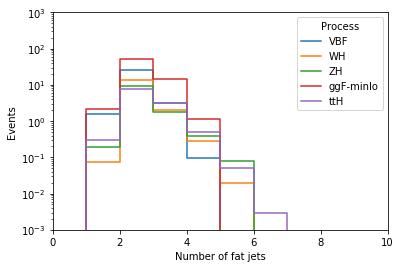

In [172]:
x = templates4.integrate('region', 'signal').sum('ddb1', 'njets')
x.label = 'Events'
axes = hist.plotgrid(x, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.001, 1000)
plt.savefig('nfatjets.png')

x.integrate('nfatjets',int_range=slice(2,8)).values()

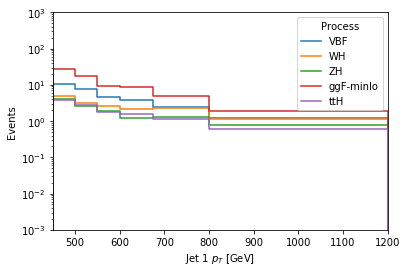

In [173]:
y = templates1.integrate('region', 'signal').sum('msd1', 'ddb1', 'n2ddt1')
y.label = 'Events'
axes = hist.plotgrid(y, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('pt1.png')

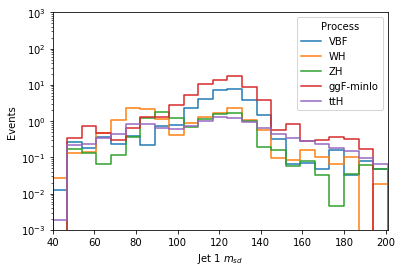

In [174]:
z = templates1.integrate('region', 'signal').sum('pt1','ddb1', 'n2ddt1')
z.label = 'Events'
axes = hist.plotgrid(z, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('msd1.png')

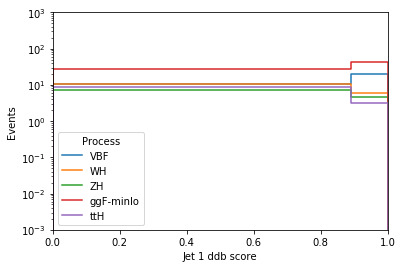

In [175]:
a = templates1.integrate('region', 'signal').sum('pt1', 'msd1', 'n2ddt1')
a.label = 'Events'
axes = hist.plotgrid(a, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('ddb1.png')

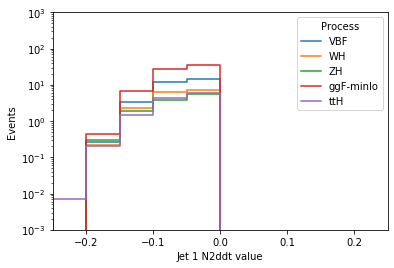

In [176]:
b = templates1.integrate('region', 'signal').sum('pt1', 'msd1', 'ddb1',)
b.label = 'Events'
axes = hist.plotgrid(b, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('n2ddt1.png')

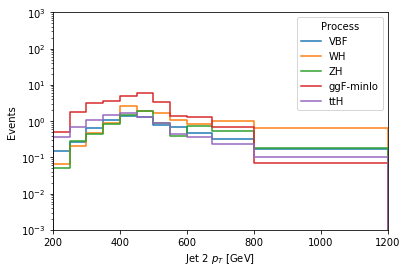

In [177]:
y = templates2.integrate('region', 'signal').sum('msd2', 'ddb2', 'n2ddt2', 'ddb1')
y.label = 'Events'
axes = hist.plotgrid(y, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('pt2.png')

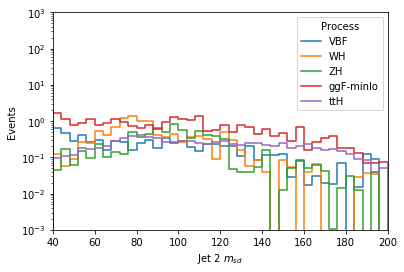

In [178]:
z = templates2.integrate('region', 'signal').sum('pt2', 'ddb2', 'n2ddt2', 'ddb1')
z.label = 'Events'
axes = hist.plotgrid(z, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('msd2.png')

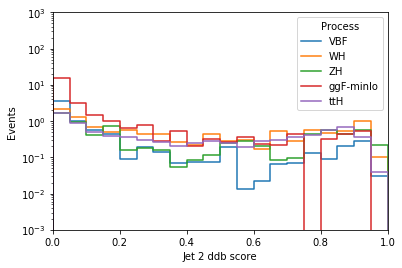

In [179]:
a = templates2.integrate('region', 'signal').sum('pt2', 'msd2', 'n2ddt2', 'ddb1')
a.label = 'Events'
axes = hist.plotgrid(a, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('ddb2.png')

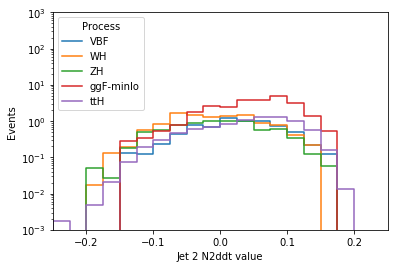

In [180]:
b = templates2.integrate('region', 'signal').sum('pt2', 'msd2', 'ddb2', 'ddb1')
b.label = 'Events'
axes = hist.plotgrid(b, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('n2ddt2.png')

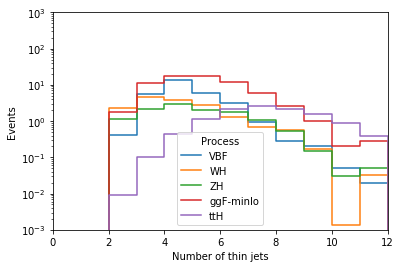

In [181]:
x = templates4.integrate('region', 'signal').sum('ddb1','nfatjets')
x.label = 'Events'
axes = hist.plotgrid(x, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('njets.png')

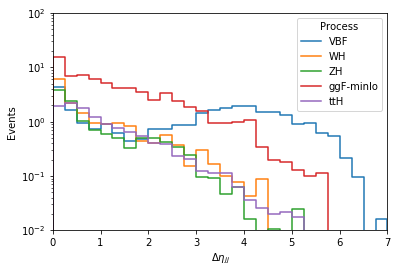

In [182]:
y = templates3.integrate('region', 'signal').sum('mjj','ddb1','qgl1','qgl2')
y.label = 'Events'
axes = hist.plotgrid(y, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 100)
plt.savefig('detajj.png')

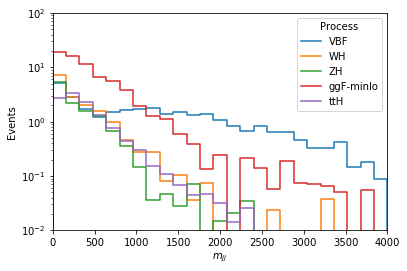

In [183]:
z = templates3.integrate('region', 'signal').sum('ddb1','deta','qgl1','qgl2')
z = z.rebin('mjj',4)
z.label = 'Events'
axes = hist.plotgrid(z, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 100)
plt.savefig('mjj.png')

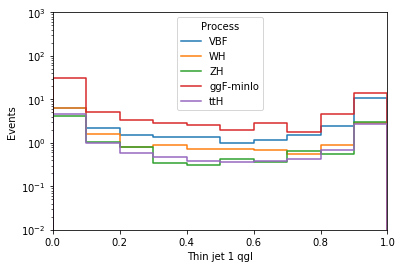

In [184]:
a = templates3.integrate('region', 'signal').sum('mjj','ddb1','deta','qgl2')
a.label = 'Events'
axes = hist.plotgrid(a, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 1000)
plt.savefig('qgl1.png')

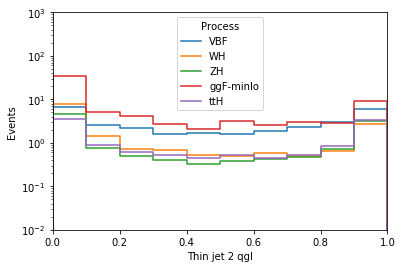

In [185]:
b = templates3.integrate('region', 'signal').sum('mjj','ddb1','deta','qgl1')
b.label = 'Events'
axes = hist.plotgrid(b, overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 1000)
plt.savefig('qgl2.png')

{('ZH',): 4.701019416499866,
 ('WH',): 5.768165247886514,
 ('ttH',): 3.007160185388552,
 ('VBF',): 18.533841604737546,
 ('ggF-minlo',): 40.478927869923794}

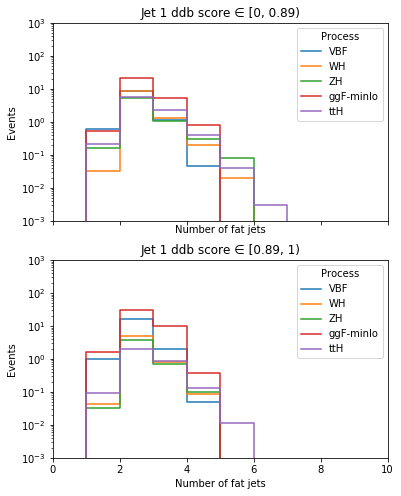

In [186]:
x = templates4.integrate('region', 'signal').sum('njets')
x.label = 'Events'
axes = hist.plotgrid(x, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.001, 1000)
plt.savefig('nfatjets_cut.png')

x.integrate('nfatjets',int_range=slice(2,8)).integrate('ddb1',int_range=slice(0.89,1)).values()

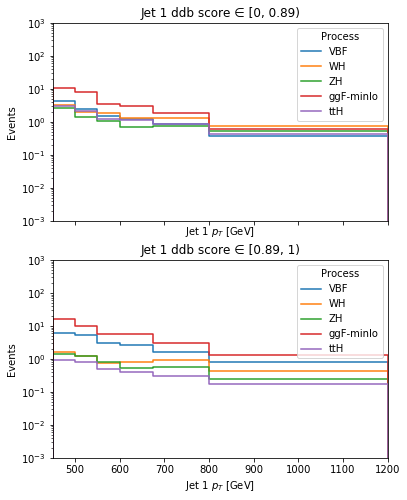

In [187]:
y = templates1.integrate('region', 'signal').sum('msd1', 'n2ddt1')
y.label = 'Events'
axes = hist.plotgrid(y, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('pt1_cut.png')

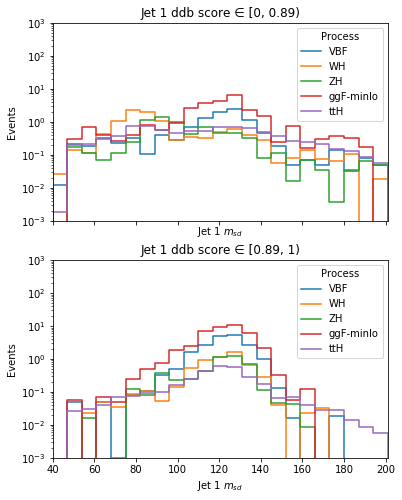

In [188]:
z = templates1.integrate('region', 'signal').sum('pt1', 'n2ddt1')
z.label = 'Events'
axes = hist.plotgrid(z, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('msd1_cut.png')

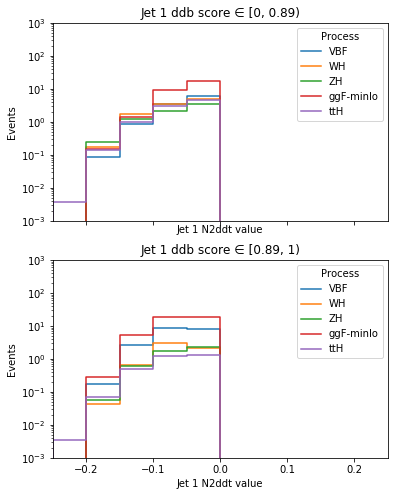

In [189]:
b = templates1.integrate('region', 'signal').sum('pt1', 'msd1')
b.label = 'Events'
axes = hist.plotgrid(b, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('n2ddt1_cut.png')

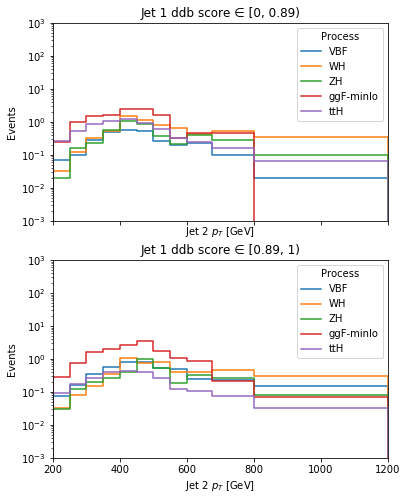

In [190]:
y = templates2.integrate('region', 'signal').sum('msd2', 'ddb2', 'n2ddt2')
y.label = 'Events'
axes = hist.plotgrid(y, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('pt2_cut.png')

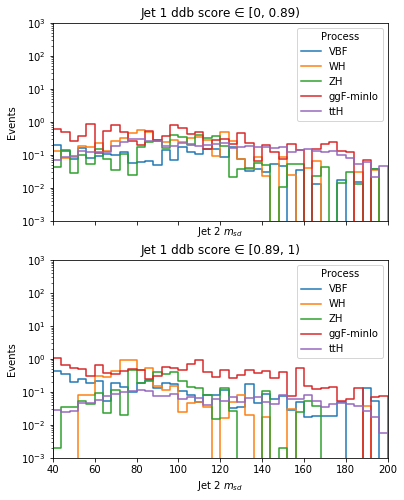

In [191]:
z = templates2.integrate('region', 'signal').sum('pt2', 'ddb2', 'n2ddt2')
z.label = 'Events'
axes = hist.plotgrid(z, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('msd2_cut.png')

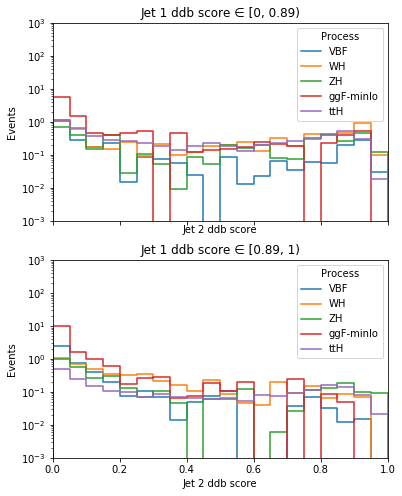

In [192]:
a = templates2.integrate('region', 'signal').sum('pt2', 'msd2', 'n2ddt2')
a.label = 'Events'
axes = hist.plotgrid(a, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('ddb2_cut.png')

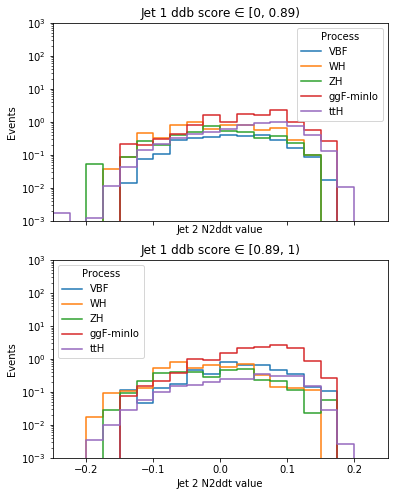

In [193]:
b = templates2.integrate('region', 'signal').sum('pt2', 'msd2', 'ddb2',)
b.label = 'Events'
axes = hist.plotgrid(b, row='ddb1', overlay='process', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(0.001, 1000)
plt.savefig('n2ddt2_cut.png')

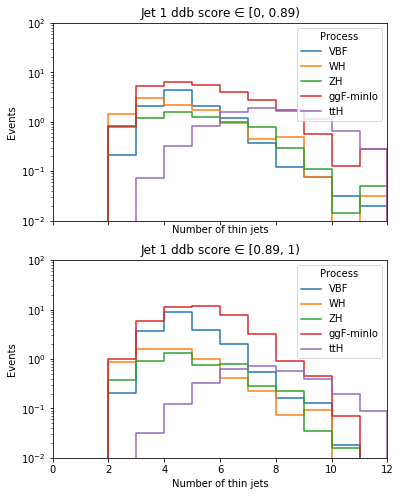

In [194]:
x = templates4.integrate('region', 'signal').sum('nfatjets')
x.label = 'Events'
axes = hist.plotgrid(x, overlay='process', row='ddb1', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 100)
plt.savefig('njets_cut.png')

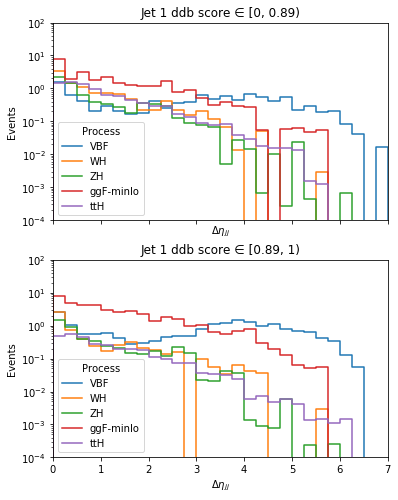

In [195]:
y = templates3.integrate('region', 'signal').sum('mjj','qgl1','qgl2')
y.label = 'Events'
axes = hist.plotgrid(y, overlay='process', row='ddb1', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.0001, 100)
plt.savefig('detajj_cut.png')

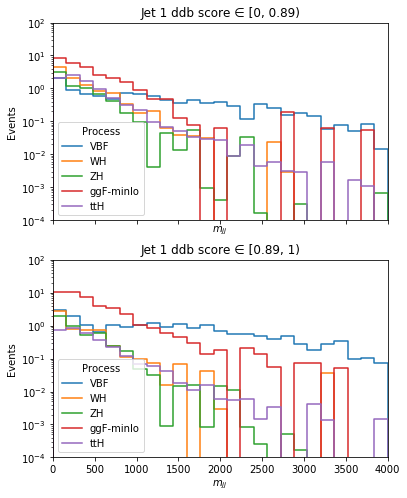

In [196]:
z = templates3.integrate('region', 'signal').sum('deta','qgl1','qgl2')
z = z.rebin('mjj',4)
z.label = 'Events'
axes = hist.plotgrid(z, overlay='process', row='ddb1', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.0001, 100)
plt.savefig('mjj_cut.png')

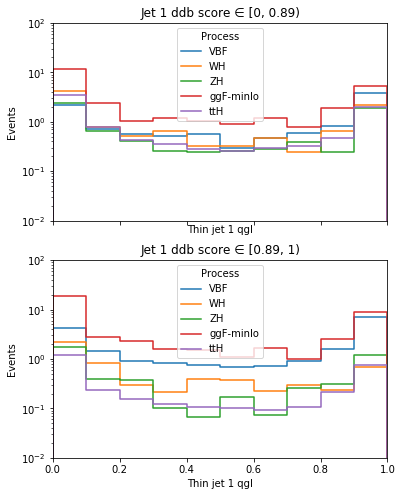

In [197]:
a = templates3.integrate('region', 'signal').sum('mjj','deta','qgl2')
a.label = 'Events'
axes = hist.plotgrid(a, overlay='process', row='ddb1', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 100)
plt.savefig('qgl1_cut.png')

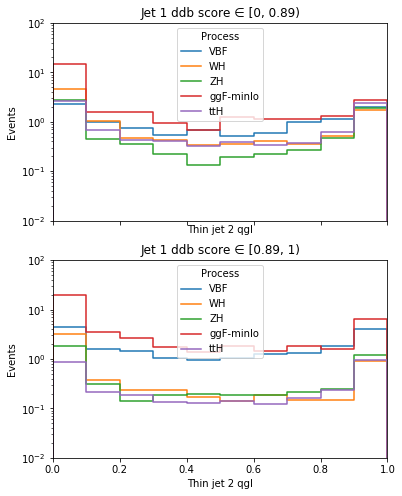

In [198]:
b = templates3.integrate('region', 'signal').sum('mjj','deta','qgl1')
b.label = 'Events'
axes = hist.plotgrid(b, overlay='process', row='ddb1', line_opts={})
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylim(.01, 100)
plt.savefig('qgl2_cut.png')

In [199]:
templates5=templates3.integrate('ddb1',int_range=slice(.89,1)).integrate('region', 'signal')

5.007862435972466
[1040.      3.25]


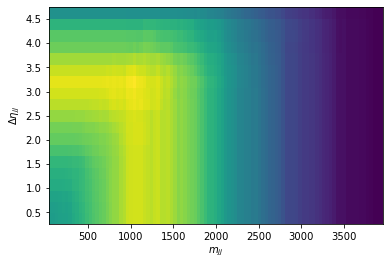

In [200]:
cuts = []
sigs = []

deta_slices = [i*0.25 for i in range(1,20)]
mjj_slices = [i*40 for i in range(1,100)]

for deta in deta_slices:
    for mjj in mjj_slices:
        sliced = templates5.sum('qgl1','qgl2').integrate('deta',int_range=slice(deta,6)).integrate('mjj',int_range=slice(mjj,4000))
        num = sliced.values()[('VBF',)]
        den = sliced.values()[('ggF-minlo',)]
                    
        sigs += [num/np.sqrt(den+1)]
        cuts += [[mjj, deta]]
        
cuts = np.array(cuts)
print(max(sigs))
print(cuts[np.argmax(sigs)])

plt.hist2d(cuts[:,0], cuts[:,1], density=False, weights=sigs, bins=[99,19]);
plt.xlabel('$m_{jj}$');
plt.ylabel('$\Delta\eta_{jj}$');
plt.savefig('vbfsigs_2d.png')

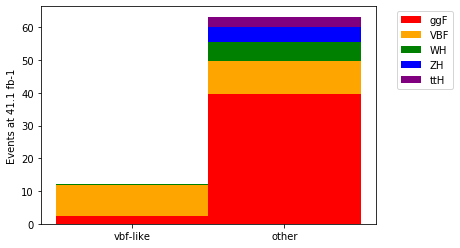

In [221]:
sr = templates5.sum('qgl1','qgl2').integrate('deta',int_range=slice(cuts[np.argmax(sigs)][1],6)).integrate('mjj',int_range=slice(cuts[np.argmax(sigs)][0],4000)).values()
yield_plot(sr, tot1.values(), 'vbf')

[0.20483923378695781, 0.6270198378079223]
[0.769118090949713, 0.16145666811241866]
[0.013859917719765604, 0.08926743489683936]
[0.0039650062568983855, 0.0741473360196272]
[0.008217751286665353, 0.04810872316319254]


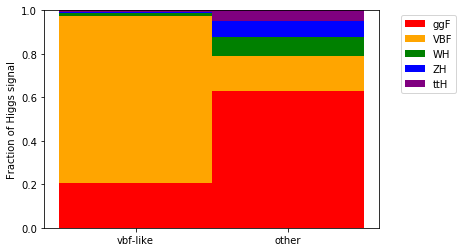

In [222]:
purity_plot(sr, tot1.values(), 'vbf')

In [203]:
cuts2 = []
sigs2 = []

qgl_slices = [i*0.1 for i in range(0,9)]
for qgl1 in qgl_slices:
    for qgl2 in qgl_slices:
        deta = cuts[np.argmax(sigs)][1]
        mjj = cuts[np.argmax(sigs)][0]

        sliced = templates5.integrate('qgl1',int_range=slice(qgl1,1)).integrate('qgl2',int_range=slice(qgl2,1)).integrate('deta',int_range=slice(deta,7)).integrate('mjj',int_range=slice(mjj,4000))
        num = sliced.values()[('VBF',)]
        den = sliced.values()[('ggF-minlo',)]  
            
        sigs2 += [num/np.sqrt(den+1)]
        cuts2 += [[qgl1, qgl2, mjj, deta]]
        
print(max(sigs2))
print(cuts2[np.argmax(sigs2)])

5.106945628567567
[0.0, 0.0, 1040.0, 3.25]


In [204]:
templates6=templates2.integrate('ddb1',int_range=slice(.89,1)).integrate('region', 'signal')

2.491344629683129
[ 64 100]


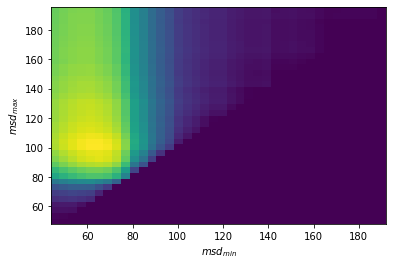

In [205]:
cuts3 = []
sigs3 = []

msd2_slices = [i*4+40 for i in range(1,40)]
for msd2_min in msd2_slices:
    for msd2_max in msd2_slices:
        if msd2_max <= msd2_min:
            continue

        sliced = templates6.sum('ddb2','pt2','n2ddt2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
        num = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs3 += [num/np.sqrt(den+1)]
        cuts3 += [[msd2_min,msd2_max]]
        
cuts3 = np.array(cuts3)
print(max(sigs3))
print(cuts3[np.argmax(sigs3)])

msd_min_vh = cuts3[np.argmax(sigs3)][0]
msd_max_vh = cuts3[np.argmax(sigs3)][1]

plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[38,38]);
plt.xlabel('$msd_{min}$');
plt.ylabel('$msd_{max}$');
plt.savefig('vh_2d_msdminmax.png')

0.9881885920531365
[ 76 104]


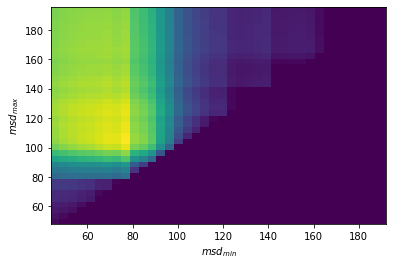

In [206]:
cuts3 = []
sigs3 = []

msd2_slices = [i*4+40 for i in range(1,40)]
for msd2_min in msd2_slices:
    for msd2_max in msd2_slices:
        if msd2_max <= msd2_min:
            continue

        sliced = templates6.sum('ddb2','pt2','n2ddt2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
        num = sliced.values()[('ZH',)] 
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs3 += [num/np.sqrt(den+1)]
        cuts3 += [[msd2_min,msd2_max]]
        
cuts3 = np.array(cuts3)
print(max(sigs3))
print(cuts3[np.argmax(sigs3)])

msd_min_zh = cuts3[np.argmax(sigs3)][0]
msd_max_zh = cuts3[np.argmax(sigs3)][1]

plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[38,38]);
plt.xlabel('$msd_{min}$');
plt.ylabel('$msd_{max}$');
plt.savefig('zh_2d_msdminmax.png')

1.7316442073178397
[64 88]


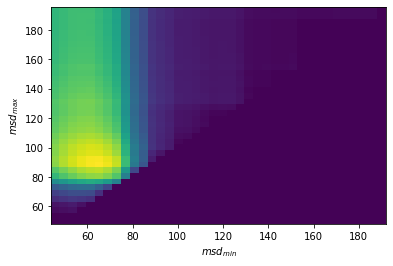

In [207]:
cuts3 = []
sigs3 = []

msd2_slices = [i*4+40 for i in range(1,40)]
for msd2_min in msd2_slices:
    for msd2_max in msd2_slices:
        if msd2_max <= msd2_min:
            continue

        sliced = templates6.sum('ddb2','pt2','n2ddt2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
        num = sliced.values()[('WH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs3 += [num/np.sqrt(den+1)]
        cuts3 += [[msd2_min,msd2_max]]
        
cuts3 = np.array(cuts3)
print(max(sigs3))
print(cuts3[np.argmax(sigs3)])

msd_min_wh = cuts3[np.argmax(sigs3)][0]
msd_max_wh = cuts3[np.argmax(sigs3)][1]

plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[38,38]);
plt.xlabel('$msd_{min}$');
plt.ylabel('$msd_{max}$');
plt.savefig('wh_2d_msdminmax.png')

In [208]:
cuts4 = []
sigs4 = []

pt2_slices = [200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800]
ddb2_slices = [i*.05 for i in range(1,20)]

for pt2 in pt2_slices:
    for ddb2 in ddb2_slices:

        msd2_min = msd_min_vh
        msd2_max = msd_max_vh
        n2ddt2 = 0.25
        
        sliced = templates6.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('ddb2',int_range=slice(ddb2,1)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
        num = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs4 += [num/np.sqrt(den+1)]
        cuts4 += [[pt2,ddb2,n2ddt2]]
        
print(max(sigs4))
print(cuts4[np.argmax(sigs4)])

2.9594549331771054
[350, 0.05, 0.25]


In [209]:
cuts4 = []
sigs4 = []

pt2_slices = [200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800]
ddb2_slices = [i*.05 for i in range(1,20)]

for pt2 in pt2_slices:
    for ddb2 in ddb2_slices:

        msd2_min = msd_min_zh
        msd2_max = msd_max_zh
        n2ddt2 = 0.25
        
        sliced = templates6.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('ddb2',int_range=slice(ddb2,1)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
        num = sliced.values()[('ZH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs4 += [num/np.sqrt(den+1)]
        cuts4 += [[pt2,ddb2,n2ddt2]]
        
print(max(sigs4))
print(cuts4[np.argmax(sigs4)])

1.0337003839759566
[250, 0.05, 0.25]


In [210]:
cuts4 = []
sigs4 = []

pt2_slices = [200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800]
ddb2_slices = [i*.05 for i in range(1,20)]

for pt2 in pt2_slices:
    for ddb2 in ddb2_slices:

        msd2_min = msd_min_wh
        msd2_max = msd_max_wh
        n2ddt2 = 0.25
        
        sliced = templates6.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('ddb2',int_range=slice(ddb2,1)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
        num = sliced.values()[('WH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs4 += [num/np.sqrt(den+1)]
        cuts4 += [[pt2,ddb2,n2ddt2]]
        
print(max(sigs4))
print(cuts4[np.argmax(sigs4)])

2.0475807757338282
[350, 0.05, 0.25]


3.1478135214881515
[3.e+02 0.e+00 5.e-02]


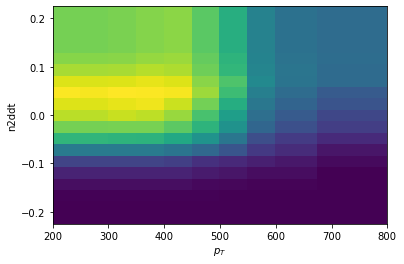

In [211]:
cuts5 = []
sigs5 = []

pt2_slices = [200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800]
n2ddt2_slices = [-0.25 + 0.025*(i) for i in range(1,20)]

for pt2 in pt2_slices:
    for n2ddt2 in n2ddt2_slices:

        msd2_min = msd_min_vh
        msd2_max = msd_max_vh
        ddb2 = 0
        
        sliced = templates6.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('ddb2',int_range=slice(ddb2,1)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
        num = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs5 += [num/np.sqrt(den+1)]
        cuts5 += [[pt2,ddb2,n2ddt2]]
        
cuts5 = np.array(cuts5)
print(max(sigs5))
print(cuts5[np.argmax(sigs5)])

plt.hist2d(cuts5[:,0], cuts5[:,2], density=False, weights=sigs5, bins=[[200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800],19]);
plt.xlabel('$p_{T}$');
plt.ylabel('n2ddt');
plt.savefig('vh_2d_n2ddtpt.png')

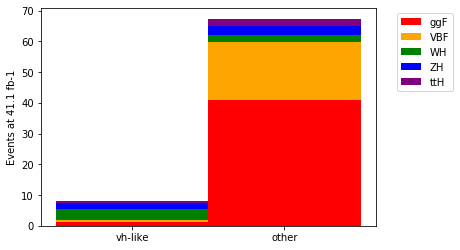

In [224]:
sr = templates6.sum('pt2','ddb2').integrate('msd2',int_range=slice(msd_min_vh,msd_max_vh)).integrate('n2ddt2',int_range=slice(-0.25,cuts5[np.argmax(sigs5)][2])).values()
yield_plot(sr, tot1.values(), 'vh')

[0.13615577933397627, 0.6087960719773043]
[0.11112475529154739, 0.2770925962712858]
[0.4451710134888168, 0.03361313941357349]
[0.23098892542442978, 0.04295112399687014]
[0.07655952646122977, 0.037547068340966334]


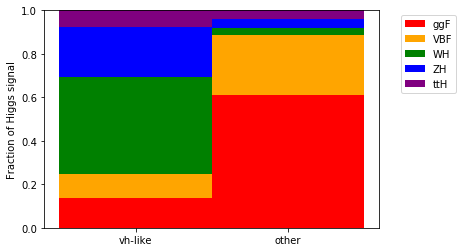

In [225]:
purity_plot(sr, tot1.values(), 'vh')

1.1691857987706238
[3.5e+02 0.0e+00 2.5e-02]


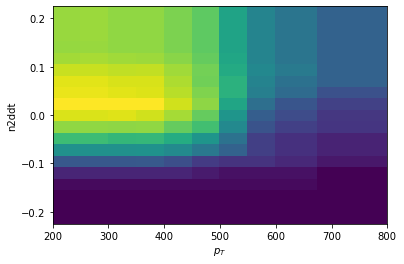

In [214]:
cuts5 = []
sigs5 = []

pt2_slices = [200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800]
n2ddt2_slices = [-0.25 + 0.025*(i) for i in range(1,20)]

for pt2 in pt2_slices:
    for n2ddt2 in n2ddt2_slices:

        msd2_min = msd_min_zh
        msd2_max = msd_max_zh
        ddb2 = 0
        
        sliced = templates6.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('ddb2',int_range=slice(ddb2,1)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
        num = sliced.values()[('ZH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs5 += [num/np.sqrt(den+1)]
        cuts5 += [[pt2,ddb2,n2ddt2]]
        
cuts5 = np.array(cuts5)
print(max(sigs5))
print(cuts5[np.argmax(sigs5)])

plt.hist2d(cuts5[:,0], cuts5[:,2], density=False, weights=sigs5, bins=[[200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800],19]);
plt.xlabel('$p_{T}$');
plt.ylabel('n2ddt');
plt.savefig('zh_2d_n2ddtpt.png')

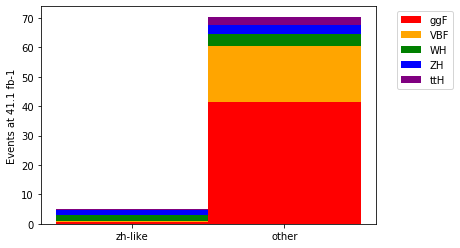

In [215]:
sr = templates6.sum('pt2','ddb2').integrate('msd2',int_range=slice(msd_min_zh,msd_max_zh)).integrate('n2ddt2',int_range=slice(-0.25,cuts5[np.argmax(sigs5)][2])).values()
yield_plot(sr, tot1.values(), 'zh')

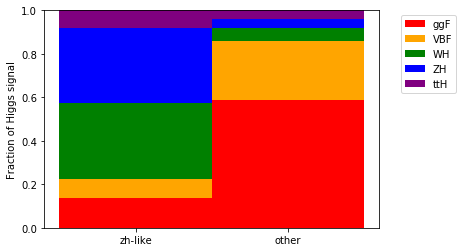

In [216]:
purity_plot(sr,tot1.values(),'zh')

2.1868620340867846
[3.e+02 0.e+00 5.e-02]


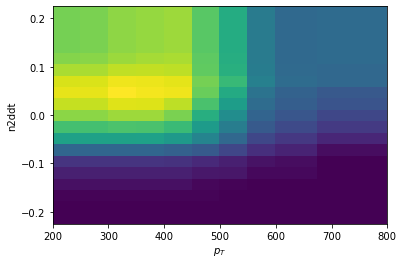

In [217]:
cuts5 = []
sigs5 = []

pt2_slices = [200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800]
n2ddt2_slices = [-0.25 + 0.025*(i) for i in range(1,20)]

for pt2 in pt2_slices:
    for n2ddt2 in n2ddt2_slices:

        msd2_min = msd_min_wh
        msd2_max = msd_max_wh
        ddb2 = 0
        
        sliced = templates6.integrate('msd2',int_range=slice(msd2_min,msd2_max)).integrate('ddb2',int_range=slice(ddb2,1)).integrate('pt2',int_range=slice(pt2,1200)).integrate('n2ddt2',int_range=slice(-0.25,n2ddt2))
        
        num = sliced.values()[('WH',)]
        den = sliced.values()[('ggF-minlo',)] + sliced.values()[('VBF',)]  
            
        sigs5 += [num/np.sqrt(den+1)]
        cuts5 += [[pt2,ddb2,n2ddt2]]
        
cuts5 = np.array(cuts5)
print(max(sigs5))
print(cuts5[np.argmax(sigs5)])

plt.hist2d(cuts5[:,0], cuts5[:,2], density=False, weights=sigs5, bins=[[200, 250, 300, 350, 400, 450, 500, 550, 600, 675, 800],19]);
plt.xlabel('$p_{T}$');
plt.ylabel('n2ddt');
plt.savefig('wh_2d_n2ddtpt.png')

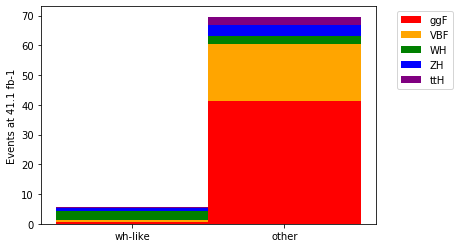

In [218]:
sr = templates6.sum('pt2','ddb2').integrate('msd2',int_range=slice(msd_min_wh,msd_max_wh)).integrate('n2ddt2',int_range=slice(-0.25,cuts5[np.argmax(sigs5)][2])).values()
yield_plot(sr, tot1.values(), 'wh')

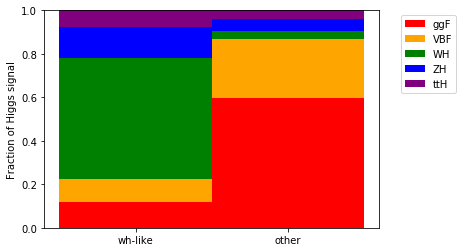

In [219]:
purity_plot(sr, tot1.values(), 'wh')